In [1]:
import os
import requests

from path import Path
import fastai.vision.all as V

subscription_key = os.environ['AZURE_SEARCH_KEY']
path = Path('images')
categories = 'la-pavoni-europiccola', 'niche-zero', 'moccamaster'

In [2]:
def search_images_bing(key, term):
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    headers = {"Ocp-Apim-Subscription-Key": key}
    params = {"q": term, "textDecorations": True, "textFormat": "HTML"}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = V.L(response.json()['value'])
    return search_results


def create_dataset(path, categories):
    if not path.exists():
        for tp in categories:
            dest = (path/tp)
            os.makedirs(dest, exist_ok=True)
            results = search_images_bing(subscription_key, f'{tp}'.replace('-', ' '))
            V.download_images(dest, urls=results.attrgot('contentUrl'))


def remove_failed_images(path):
    image_paths = V.get_image_files(path)
    failed_images = V.verify_images(image_paths)
    return failed_images.map(Path.unlink)            

In [3]:
create_dataset(path, categories)
remove_failed_images(path)

/home/marcus/anaconda3/envs/coffee/lib/python3.6/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/marcus/anaconda3/envs/coffee/lib/python3.6/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/marcus/anaconda3/envs/coffee/lib/python3.6/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#8) [Path('images/niche-zero/00000029.jpg'),Path('images/moccamaster/00000031.jpg'),Path('images/moccamaster/00000027.png'),Path('images/moccamaster/00000007.jpg'),Path('images/moccamaster/00000021.jpg'),Path('images/la-pavoni-europiccola/00000000.png'),Path('images/la-pavoni-europiccola/00000023.jpg'),Path('images/la-pavoni-europiccola/00000001.jpg')]

In [4]:
data_block = V.DataBlock(
    blocks=(V.ImageBlock, V.CategoryBlock),
    get_items=V.get_image_files,
    splitter=V.RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=V.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=V.aug_transforms(),
    get_y=V.parent_label,
)

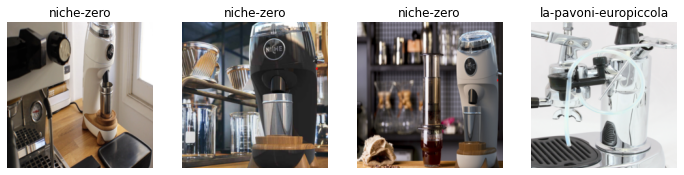

In [5]:
dls = data_block.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Create model using transfer learning

In [6]:
learn = V.cnn_learner(dls, V.resnet18, metrics=V.error_rate)

### Fine tune model

In [7]:
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,1.787410,3.653442,0.631579,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.759272,2.801371,0.578947,00:04
1,1.465077,2.232194,0.526316,00:04
2,1.219033,1.610842,0.473684,00:04
3,1.000690,0.998681,0.421053,00:04
4,0.844701,0.570246,0.210526,00:04
5,0.705412,0.389614,0.157895,00:04
6,0.618549,0.243479,0.157895,00:04
7,0.548552,0.134533,0.105263,00:04
8,0.485171,0.073794,0.052632,00:04
9,0.432653,0.046299,0.000000,00:04


### Confusion Matrix 

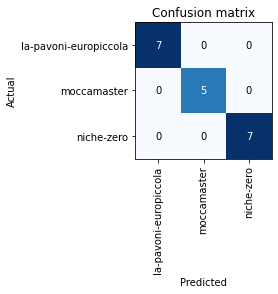

In [8]:
interp = V.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Top Losses

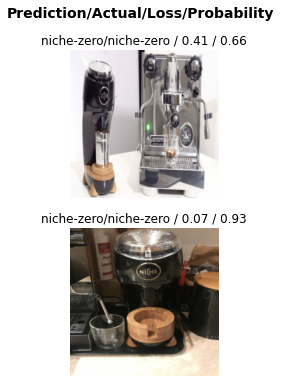

In [9]:
interp.plot_top_losses(2, nrows=2)